# Lecture 14: Computational Modeling

CBIO (CSCI) 4835/6835: Introduction to Computational Biology

## Overview and Objectives

So far, we've discussed Hidden Markov Models as way to encapsulate and represent something with a "hidden state" component. There are countless other computational and statistical models, a few of which we'll touch on here. By the end of this lecture, you should be able to:

 - Understand compartment models and how to design them
 - Relate ordinary differential equations (ODEs) to compartment models
 - Implement basic compartment models for population growth, disease spread, and competition

## Part 1: Compartment Models

A *compartment model* is one of the simplest mechanistic representations of real-world phenomena.

All compartment models look something like this:

![singlecell](ComputationalModeling/Singlecell.PNG)

 - The node(s) represent specific compartments in the model
 - The edge(s) represent flow of material from one compartment to another, as well as dependencies between compartments
 - Because of the fact that things are constantly moving around in compartment models, they are sometimes also referred to as *dynamic models*

There are lots of variations on this theme, including:

 - **Closed models**: Total amount of material within the model remains constant, simply shifting from one compartment to another

 - **Open models**: Total material can flow in and out of the model's compartments. This is referred to the model having a *source* (an external contributor of additional material) or a *sink* (a compartment where material effectively disappears from the model when it enters)

 - **Cyclic models**: Material can flow back and forth between mutually connected compartments

Or combinations of the above!

Compartment models can be *discrete* or *continuous*.

 - **Discrete models** consider the passage of time in discrete steps, e.g. integers.

![singlecell](ComputationalModeling/Singlecell.PNG)

In this example, the input of the compartment $u(t)$ is dependent on time, where time is a discrete quantity.

 - **Continuous models**, on the other hand, shrink the change in time between events ($\delta t$) to 0.

![continuous](ComputationalModeling/continuous.png)

We'll see some examples where this formulation may make more sense. Unfortunately, this is often much more difficult to derive for certain systems.

Compartment models can also be *deterministic* or *stochastic*.

 - **Deterministic models** give you the exact same outputs for any given input. This is what we'll see with models that use differential equations: for given initial values to the system, we always get the same final values.

 - **Stochastic models** introduce randomness into systems, simulating probabilities instead of explicit differential equations. These provide much more realistic looks into real-world systems, but are often much more difficult to analyze (e.g. for steady states), since a given input will not always (or ever!) give the same output.

An offshoot of stochastic models is the **agent-based model**, in which individual "agents" are allowed to act independently according to certain probabilities. This is a very powerful, but very compute-intensive, model.

## Part 2: Common Dynamic Models

Enough vocabulary; let's look at a couple common dynamic models.

### Population Growth

We'd like to model the growth of some population (humans, animals, bacteria, etc). There are two generally-accepted ways of doing this:

 - **Exponential growth** assumes that the population grows, well, exponentially. There are implicit assumptions here as well, most importantly that resources also grow with population to sustain its growth.

 - **Logistic growth** assumes a little more explicitly that the amount of some critical resource (e.g. food) is fixed, effectively providing an upper bound on the ultimate size of the population.

Let's take a look!

**Exponential growth** sounds a little misleading, since the equation doesn't, on initial inspection, *look* exponential.

Let's say your population can grow through birth, and shrink through death. At any given time $t$, the population is offset by the number added (birth) and removed (death).

With this information, can we build an equation for population as a function of time?

$n(t + 1) = n(t) + b - d$

Or perhaps, put another way, the *change* in population at any given time?

$\frac{dn}{dt} = bn(t) - dn(t)$

 - $b$ is the birth rate
 - $d$ is the death rate
 - $n(t)$ is the population at time $t$

You may notice both terms in the above equation have a common element that can be factored out.

$\frac{dn}{dt} = n(t) (b - d)$

The $(b - d)$ term even has a special name: the *per capita rate of change*. It essentially governs whether the population is increasing or decreasing at any given time, depending on whether the birth or death term dominates. It is typically represented as $r_c = b - d$, so we can rewrite the equation as simply:

$\frac{dn}{dt} = r_c n(t)$

Now that we've gone through the derivation of the differential equations, how about some nice pretty pictures?

![growthexp](ComputationalModeling/growth-exp.png)

Compartment models lend themselves to these sorts of diagrams, which make setting up equations (and, eventually, transition matrices) a lot simpler. 

So we have these equations; how do we run them and obtain some results?

Turns out, Python (specifically, SciPy) has a module for solving ordinary differential equations (ODEs).

In [1]:
# Preliminary imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as sig  # Here's the critical module!
import seaborn as sns

Now, let's set an initial population $n_0$, pick a couple of different per capita rates of change $r_c$, and run them to see what happens.

In [2]:
n0 = 10
rc1 = 0.01
rc2 = 0.1
rc3 = -0.2

The one critical part of the whole thing: you have to define the differential equations as Python functions, so the SciPy module knows what to solve. Let's do that here:

In [3]:
# Differential equation functions take two arguments: the variable that's changing, and time.
def diffeq(n, t):
    return n * rc

Now, let's create a bunch of time points and evaluate the ODE for different values of `rc`!

In [4]:
t = np.linspace(0, 15,  1000)  # time

rc = rc1
n1, oded = sig.odeint(diffeq, n0, t, full_output = True)
print(oded['message'])

rc = rc2
n2, oded = sig.odeint(diffeq, n0, t, full_output = True)
print(oded['message'])

rc = rc3
n3, oded = sig.odeint(diffeq, n0, t, full_output = True)
print(oded['message'])

Integration successful.
Integration successful.
Integration successful.


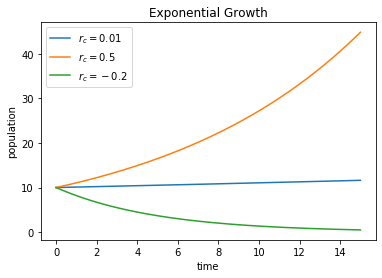

In [5]:
plt.xlabel('time')
plt.ylabel('population')
plt.title('Exponential Growth')
plt.plot(t, n1, label = '$r_c = 0.01$')
plt.plot(t, n2, label = '$r_c = 0.5$')
plt.plot(t, n3, label = '$r_c = -0.2$')
plt.legend(loc = 0)

**Logistic growth** is a slightly different approach. It takes into account the fact that populations usually can't just keep growing without bound. In fact, their growth rate is directly related to their current size.

The model looks something like this:

![growthlog](ComputationalModeling/growth-log.png)

You still see some of the usual suspects--population $n(t)$ as a function of time, and birth and death rates, but notice the latter two are also now *functions of the current population* instead of simply constants.

To come up with a bounded model of population growth, we need to add a couple of things to our original equation.

Think of it this way: when the population is *small*, we want it to behave more or less like it did before--exponential growth. But when the population is *large*, we want it slow down or even stop growing.

$\frac{dn}{dt} = r_c n(t) (1 - \frac{n(t)}{K})$

Let's look at this more closely:
 - We still see the same exponential growth equation as before in the first part
 - There's a second part, though: $(1 - \frac{n(t)}{K})$
 - Consider the equation when $n(t)$ is small: the $\frac{n(t)}{K}$ number is close to 0, which means $1 -$ that number is pretty much 1, so the equation reduces to $r_c n(t)$, exactly what we had before!
 - When $n(t)$ is large--say, very close to whatever $K$ is--the fraction $\frac{n(t)}{K}$ is very close to 1, and $1 - 1 = 0$, which sets the entire equation to 0. In other words, growth stops completely!

So that's cool. Let's plot it out with Python! Remember to first set up the variables and rates:

In [6]:
# Same as before
n0 = 10
rc1 = 0.01
rc2 = 0.1
rc3 = -0.2
K = 100    # The new term introduced by this method--known as "Carrying Capacity"

Now we need to write the function that implements the differential equation.

In [7]:
def logistic_growth(n, t):
    exp_term = n * rc  # same as before
    limit_term = 1 - (n / K)  # the limiting term
    return exp_term * limit_term

Now we simulate it! The only difference is, this time, we feed the function name `logistic_growth` to the `odeint()` solver:

In [8]:
t = np.linspace(0, 100,  2000)  # time

rc = rc1
n1, oded = sig.odeint(logistic_growth, n0, t, full_output = True)
print(oded['message'])

rc = rc2
n2, oded = sig.odeint(logistic_growth, n0, t, full_output = True)
print(oded['message'])

rc = rc3
n3, oded = sig.odeint(logistic_growth, n0, t, full_output = True)
print(oded['message'])

Integration successful.
Integration successful.
Integration successful.


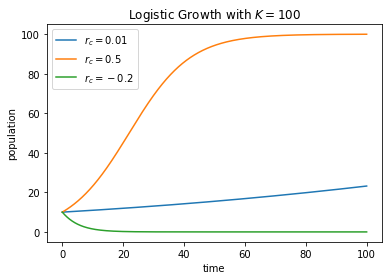

In [9]:
plt.xlabel('time')
plt.ylabel('population')
plt.title('Logistic Growth with $K = 100$')
plt.plot(t, n1, label = '$r_c = 0.01$')
plt.plot(t, n2, label = '$r_c = 0.5$')
plt.plot(t, n3, label = '$r_c = -0.2$')
plt.legend(loc = 0)

### Models of Competition

The population growth models we looked at are great, but they're unrealistic for many reasons, not the least of which is: populations don't exist in a vacuum!

Populations have to coexist with restrictions such as food, water, resources, mating and fertility rates, environmental factors, and numerous others.

**Lotka-Volterra models** build on the idea of logistic population growth, but with the added constraint of an additional population species that specifically preys on the other.

Consider a model of 2 species with the following parameters:

 - Populations $n_1$ and $n_2$

 - Intrinsic growth rates $r_1$ and $r_2$

 - Carrying capacities $K_1$ and $K_2$

**Assumptions**

(always important to list these out!)

 - The prey population finds ample food at all times, whereas the predator population's food depends solely on the prey population

 - Related: the predator has an unlimited appetite (i.e. the amount of food consumed by predators is dependent only on the population size of the prey)

 - The rate of change in both populations is a function of the sizes of the populations

 - The environment the two populations reside in doesn't change, and genetics / adaptation don't play a role

How do we set up the competing differential equations?

Start with the exponential growth from before!

**Prey growth:** $\frac{dx}{dt} = \alpha x$

But we want to include a negative dependence on the predator population, too.

 - This negative dependence has its own rate, $\beta$.
 - Predation rate is not only dependent on the predator population $y$, but also the prey population $x$.
 - **So the negative term is composed of three elements**.

**Prey:** $\frac{dx}{dt} = \alpha x - \beta x y$

How about the predator equations?

(Hint: the part of the prey equation that kills off prey is what contributes to predator growth)

**Predator growth:** $\frac{dy}{dt} = \gamma x y$

That's the growth term for predators. How about its own negative term?

**Predator:** $\frac{dy}{dt} = \gamma x y - \delta y$

Let's model these equations in Python!

First, we have parameter values we need to set up:

In [10]:
a = 1.0   # prey growth rate
b = 0.1   # predation rate (prey death rate)
c = 0.075 # predator growth rate
d = 1.0   # predator death rate

Next, we need to code up one step of the differential equation, in the form of a Python function:

In [11]:
def pred_prey(X, t):
    # Remember: X is a two-element NumPy array
    ax = a * X[0]
    bxy = b * X[0] * X[1]
    cxy = c * X[0] * X[1]
    dy = d * X[1]
    
    # Return value is also a two-element array
    retval = np.array([ax - bxy, cxy - dy])
    return retval

How does it look?

In [12]:
t = np.linspace(0, 15,  1000)  # time
X0 = np.array([10, 5])         # initials conditions: 10 prey, 5 predators
X, oded = sig.odeint(pred_prey, X0, t, full_output = True)
print(oded['message'])

Integration successful.


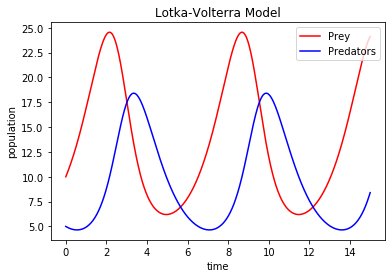

In [13]:
prey, pred = X.T

plt.xlabel('time')
plt.ylabel('population')
plt.title('Lotka-Volterra Model')
plt.plot(t, prey, 'r-', label = 'Prey')
plt.plot(t, pred  , 'b-', label = 'Predators')
plt.legend(loc = 0)

### Epidemiological Models

There is an entire class of compartment models dedicated to capturing the characteristics of epidemiological systems, the most popular of which is easily the *SIR model*.

**SIR models**, or *Susceptible-Infected-Recovered* models, represent three distinct populations and how people move from one of these populations to another in response to infectious diseases.

![siroverview](ComputationalModeling/sir-overview.png)

Let's create a diagram of the process, just as before, showing the relevant variables, parameters, constraints, and interactions between variables.

To start, we need to list out our background knowledge of the problem, encoded as assumptions:

 - Infection can be transmitted from infected to susceptible individuals
 - Recovered individuals become immune for a period of time
 - Probability of death is increased in infected patients

Can we sketch out the diagram?

![sirdiagram](ComputationalModeling/sir-diagram.png)

Next step: convert the diagram into equations or rules (we've used differential equations so far), one for each population.

Susceptible population:

$\frac{dS}{dt} = \theta + \sigma R(t) - \beta S(t) I(t) - \sigma S(t)$

Infected population:

$\frac{dI}{dt} = \beta S(t) I(t) - \rho I(t) - \delta I(t)$

Recovered population:

$\frac{dR}{dt} = \rho I(t) - \sigma R(t) - \mu R(t)$

**Aside**

We're leaving out for the moment how exactly to come up with values for all these parameters; it's more obvious with SIR parameters, since there are a ton of them.

Research papers using the model will detail out the values used and how they were determined (often through simulation or experiment).

Let's see if we can simulate this model!

In [14]:
beta = 0.3   # infection rate
theta = 10.0 # birth rate
sigma = 0.5  # de-immunization rate
rho = 0.9    # recovery rate
delta = 0.5  # death rate from infection
mu = 0.05    # death rate from susceptibility or recovery

# Initial populations.
S0 = 100
I0 = 5
R0 = 0

X0 = np.array([S0, I0, R0])

Now we need to code up the differential equations in terms of Python functions.

In [15]:
def diff_sir(X, t):
    s = X[0]
    i = X[1]
    r = X[2]
    
    # Now, compute each equation.
    ds = theta + (sigma * r) - (beta * s * i) - (mu * s)
    di = (beta * s * i) - (rho * i) - (delta * i)
    dr = (rho * i) - (sigma * r) - (mu * r)

    # Return the numbers as an array, in the same order as the input.
    return np.array([ds, di, dr])

Finally, we'll solve the equation.

Integration successful.


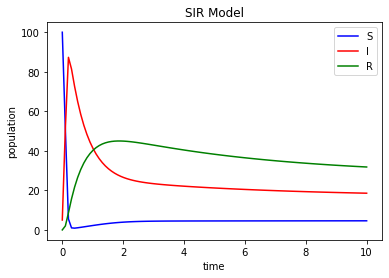

In [16]:
t = np.linspace(0, 10,  100)  # time
Y, oded = sig.odeint(diff_sir, X0, t, full_output = True)
print(oded['message'])

S, I, R = Y.T

plt.xlabel('time')
plt.ylabel('population')
plt.title('SIR Model')
plt.plot(t, S, 'b-', label = 'S')
plt.plot(t, I, 'r-', label = 'I')
plt.plot(t, R, 'g-', label = 'R')
plt.legend(loc = 0)

This could be used to predict, for example, the peak of an upcoming influenza season.

### Compartment Models Summary

The models we've looked at so far (population, competition, epidemiological) are

 - Deterministic

 - Temporal (definitely *not* spatial)

 - Grounded by very strong assumptions

 - **Flexible**

Possible extensions include:

 - Additional species/populations and dependencies between them

 - Environmental, genetic, and/or spatial components

 - Analysis of the phase plane to determine steady states in the models

 - ???

General strategy for building compartment models:

![modelofmakingmodels](ComputationalModeling/model-of-making-models.png)

## Administrivia

 - Assignment 3 is due **today!** Last assignment before the midterm!

 - Will hopefully have everything graded this weekend.

 - Reminder: the midterm exam is **next Tuesday, in the Miller Learning Center, room 368.** It's at the regular lecure time, so DO NOT COME TO THIS CLASSROOM NEXT TUESDAY!

## Additional Resources



 - SciPy ODE integration documents https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
 - Lotka-Volterra Python tutorial http://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html 